In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict, deque

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


# Load the dataset for recommenders

In [2]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [3]:
def n_to_p(l):
    n = sum(l)
    return [x / n for x in l] if n > 0 else l

def calculate_p(x, values):
    counts = [0]*len(values)
    
    x = [incom_x for incom_x in x if str(incom_x) != 'nan']
    
    for v in x:
        counts[values.index(v)] += 1

    return n_to_p(counts)

def prepare_users_df(interactions_df):

    users_df = interactions_df.loc[:, ["user_id"]]
    users_df = users_df.groupby("user_id").first().reset_index(drop=False)
    
    user_features = []

    for column in base_item_features:

        column_values = column_values_dict[column]
        df = interactions_df.loc[:, ['user_id', column]]
        df = df.groupby('user_id').aggregate(lambda x: list(x)).reset_index(drop=False)

        def calc_p(x):
            return calculate_p(x, column_values)

        df.loc[:, column] = df[column].apply(lambda x: calc_p(x))

        p_columns = []
        for i in range(len(column_values)):
            p_columns.append("user_" + column + "_" + column_values[i])
            df.loc[:, p_columns[i]] = df[column].apply(lambda x: x[i])
            user_features.append(p_columns[i])

        users_df = pd.merge(users_df, df.loc[:, ['user_id'] + p_columns], on=["user_id"])
    
    return users_df, user_features
    

users_df, user_features = prepare_users_df(interactions_df)

print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

['user_term_WinterVacation', 'user_term_Easter', 'user_term_OffSeason', 'user_term_HighSeason', 'user_term_LowSeason', 'user_term_MayLongWeekend', 'user_term_NewYear', 'user_term_Christmas', 'user_length_of_stay_bucket_[0-1]', 'user_length_of_stay_bucket_[2-3]', 'user_length_of_stay_bucket_[4-7]', 'user_length_of_stay_bucket_[8-inf]', 'user_rate_plan_Standard', 'user_rate_plan_Nonref', 'user_room_segment_[0-160]', 'user_room_segment_[160-260]', 'user_room_segment_[260-360]', 'user_room_segment_[360-500]', 'user_room_segment_[500-900]', 'user_n_people_bucket_[1-1]', 'user_n_people_bucket_[2-2]', 'user_n_people_bucket_[3-4]', 'user_n_people_bucket_[5-inf]', 'user_weekend_stay_True', 'user_weekend_stay_False']


,user_id,user_term_WinterVacation,user_term_Easter,user_term_OffSeason,user_term_HighSeason,user_term_LowSeason,user_term_MayLongWeekend,user_term_NewYear,user_term_Christmas,user_length_of_stay_bucket_[0-1],user_length_of_stay_bucket_[2-3],user_length_of_stay_bucket_[4-7],user_length_of_stay_bucket_[8-inf],user_rate_plan_Standard,user_rate_plan_Nonref,user_room_segment_[0-160],user_room_segment_[160-260],user_room_segment_[260-360],user_room_segment_[360-500],user_room_segment_[500-900],user_n_people_bucket_[1-1],user_n_people_bucket_[2-2],user_n_people_bucket_[3-4],user_n_people_bucket_[5-inf],user_weekend_stay_True,user_weekend_stay_False
0,1,0.090909,0.0,0.681818,0.090909,0.136364,0.000000,0.000000,0.0,0.000000,0.590909,0.409091,0.000000,0.500000,0.500000,0.000000,0.863636,0.136364,0.000000,0.0,0.000000,0.727273,0.181818,0.090909,0.772727,0.227273
40,50,0.043478,0.0,0.434783,0.304348,0.217391,0.000000,0.000000,0.0,0.000000,0.913043,0.086957,0.000000,0.260870,0.739130,0.000000,0.565217,0.434783,0.000000,0.0,0.000000,0.173913,0.521739,0.304348,0.782609,0.217391
84,96,0.090909,0.0,0.681818,0.136364,0.045455,0.045455,0.000000,0.0,0.272727,0.636364,0.045455,0.045455,0.272727,0.727273,0.045455,0.863636,0.090909,0.000000,0.0,0.045455,0.272727,0.590909,0.090909,0.727273,0.272727
102,115,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.333333,0.333333,1.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.0,0.333333,0.000000,0.000000,0.666667,0.333333,0.666667
371,706,0.111888,0.0,0.482517,0.174825,0.160839,0.055944,0.013986,0.0,0.237762,0.384615,0.216783,0.160839,0.986014,0.013986,0.021127,0.823944,0.126761,0.028169,0.0,0.104895,0.090909,0.678322,0.125874,0.650350,0.349650
1385,1736,0.034483,0.0,0.482759,0.206897,0.275862,0.000000,0.000000,0.0,0.241379,0.551724,0.206897,0.000000,0.172414,0.827586,0.000000,0.931034,0.034483,0.034483,0.0,0.379310,0.413793,0.206897,0.000000,0.448276,0.551724
7314,7779,0.000000,0.0,0.300000,0.100000,0.600000,0.000000,0.000000,0.0,0.100000,0.200000,0.600000,0.100000,1.000000,0.000000,0.000000,0.700000,0.300000,0.000000,0.0,0.000000,0.000000,0.900000,0.100000,0.600000,0.400000


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [4]:
def map_items_to_onehot(df):
    one_hot = pd.get_dummies(df.loc[:, base_item_features])
    df = df.drop(base_item_features, axis = 1)
    df = df.join(one_hot)
    
    return df, list(one_hot.columns)

def prepare_items_df(interactions_df):
    items_df = interactions_df.loc[:, ["item_id"] + base_item_features].drop_duplicates()
    
    items_df, item_features = map_items_to_onehot(items_df)
    
    return items_df, item_features


items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

['term_WinterVacation', 'term_Easter', 'term_OffSeason', 'term_HighSeason', 'term_LowSeason', 'term_MayLongWeekend', 'term_NewYear', 'term_Christmas', 'length_of_stay_bucket_[0-1]', 'length_of_stay_bucket_[2-3]', 'length_of_stay_bucket_[4-7]', 'length_of_stay_bucket_[8-inf]', 'rate_plan_Standard', 'rate_plan_Nonref', 'room_segment_[0-160]', 'room_segment_[160-260]', 'room_segment_[260-360]', 'room_segment_[360-500]', 'room_segment_[500-900]', 'n_people_bucket_[1-1]', 'n_people_bucket_[2-2]', 'n_people_bucket_[3-4]', 'n_people_bucket_[5-inf]', 'weekend_stay_True', 'weekend_stay_False']


,item_id,term_WinterVacation,term_Easter,term_OffSeason,term_HighSeason,term_LowSeason,term_MayLongWeekend,term_NewYear,term_Christmas,length_of_stay_bucket_[0-1],length_of_stay_bucket_[2-3],length_of_stay_bucket_[4-7],length_of_stay_bucket_[8-inf],rate_plan_Standard,rate_plan_Nonref,room_segment_[0-160],room_segment_[160-260],room_segment_[260-360],room_segment_[360-500],room_segment_[500-900],n_people_bucket_[1-1],n_people_bucket_[2-2],n_people_bucket_[3-4],n_people_bucket_[5-inf],weekend_stay_True,weekend_stay_False
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0
6,6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [5]:
from recommenders.recommender import Recommender

class MLPModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc1 = nn.Linear(2 * embedding_dim, 32, bias=False)
        self.fc2 = nn.Linear(32, 16, bias=False)
        self.fc3 = nn.Linear(16, 1, bias=False)

    def forward(self, x):
        user = x[:, 0]
        item = x[:, 1]
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        x = torch.cat([user_embedding, item_embedding], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x
    
class GMFModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 1, bias=False)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        x = self.fc(user_embedding * item_embedding)
        x = torch.sigmoid(x)

        return x
    
class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    
    def __init__(self, seed=6789, n_neg_per_pos=10,  **params):
        """
        Initialize base recommender params and variables.
        """
        self.model = None
        self.n_neg_per_pos = n_neg_per_pos
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        
        self.r = None
        self.item_id_mapping = None
        self.interactions_df = None
        
        if 'embedding_dim' in params:
            self.embedding_dim = params['embedding_dim']
        else:
            self.embedding_dim = 6
        
        if 'device' in params:
            self.device = params['device']
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            
        if 'lr' in params: 
            self.lr = params['lr']
        else:
            self.lr = 0.001
            
        if 'weight_decay' in params: 
            self.weight_decay = params['weight_decay']
        else:
            self.weight_decay = 0.0001
            
        if 'n_epochs' in params: 
            self.n_epochs = int(params['n_epochs'])
        else:
            self.n_epochs = 25
            
        if 'should_save_model' in params:
            self.should_save_model = params['should_save_model']
            
        if 'print_type' in params:
            self.print_type = params['print_type']
        else:
            self.print_type = 'live'
            
        if 'train' in params:
            self.train = params['train']
        else:
            self.train = True
            
        if 'batch_size' in params:
            self.batch_size = params['batch_size']
        else:
            self.batch_size = 16
            
        # MLPModel ||  GMFModel       
        if 'modelClass' in params:
            self.modelClass = params['modelClass']
        else:
            self.modelClass = 'MLPModel'
            
        if 'should_recommend_already_bought' in params:
            self.should_recommend_already_bought = params['should_recommend_already_bought']
        else:
            self.should_recommend_already_bought = False
        
        self.validation_set_size = 0.2
        
    def generate_negative_interactions_list(self, n):
        n_items = np.max(interactions_df['item_id']) + 1
        n_users = np.max(interactions_df['user_id']) + 1

        r = np.zeros(shape=(n_users, n_items))
        for idx, interaction in interactions_df.iterrows():
            r[int(interaction['user_id'])][int(interaction['item_id'])] = 1
            
        self.r = r
        
        negative_interactions = []

        for i1, i2 in enumerate(r):
            for j1, j2 in enumerate(i2):
                if j2 == 0:
                    negative_interactions.append((i1, j1, 0))
    
    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """
        
        del users_df, items_df
        
        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))
                
        interactions_df = interactions_df.copy()
        interactions_df.replace({'item_id': self.item_id_mapping, 'user_id': self.user_id_mapping}, inplace=True)     
        
        self.interactions_df = interactions_df.copy()
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1
        
        #  ---start---
        interactions_df.loc[:, 'interacted'] = 1
        negative_interactions = self.generate_negative_interactions_list(self.n_neg_per_pos * len(interactions_df))
        #  ---end---
        
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        interactions_df = interactions_df.reset_index(drop=True)
        # Initialize the neural network model
        
        #  ---start---       
        if self.print_type is not None and self.print_type == 'live':
            liveloss = PlotLosses()

        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_training_total_loss = 0.0
        last_validation_total_loss = 0.0
        
        if self.modelClass == 'GMFModel':
            self.nn_model = GMFModel(n_items, n_users, self.embedding_dim, self.seed)
        elif self.modelClass == 'MLPModel':
            self.nn_model = MLPModel(n_items, n_users, self.embedding_dim, self.seed)
        
        self.nn_model.train()
        self.nn_model.to(self.device)
        self.optimizer = optim.Adam(self.nn_model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        interaction_ids = self.rng.permutation(len(interactions_df))
        train_validation_slice_idx = int(len(interactions_df) * (1 - self.validation_set_size))
        training_ids = interaction_ids[:train_validation_slice_idx]
        validation_ids = interaction_ids[train_validation_slice_idx:]
        
        #  ---end---
        
        # Train the model using an optimizer
        
         #  ---start---
            
        for epoch in range(self.n_epochs):
            if self.print_type is not None and self.print_type == 'live':
                logs = {}
                
            # Train
            
            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / self.batch_size))
            
            for batch_idx in range(n_batches):
                
                batch_ids = training_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                
                batch = interactions_df.loc[batch_ids]


                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values.astype(np.int64)).long().to(self.device)
    
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values.astype(np.float64)).float().to(self.device)
                
                y = self.nn_model(batch_input).clip(0.000001, 0.999999)

                # Define loss and backpropagate

                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item()
                
                if self.print_type is not None and self.print_type == 'text':
                    print("\rEpoch: {}\tBatch: {}\tLast epoch - avg training loss: {:.2f} avg validation loss: {:.2f} loss: {}".format(
                        epoch, batch_idx, last_training_total_loss, last_validation_total_loss, loss), end="")
                
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))               
                
            # Validate

            validation_total_loss = 0.0
            
            batch = interactions_df.loc[validation_ids]
            
            batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values.astype(np.int64)).long().to(self.device)
    
            y_target = torch.from_numpy(batch.loc[:, ['interacted']].values.astype(np.float64)).float().to(self.device)
                
            # Create responses

            y = self.nn_model(batch_input).clip(0.000001, 0.999999)

            # Calculate validation loss

            loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
            validation_total_loss += loss.item()
                
            # Save and print epoch losses
            
            training_last_avg_loss = training_total_loss / len(training_ids)
            validation_last_avg_loss = validation_total_loss / len(validation_ids)

            if self.print_type is not None and self.print_type == 'live' and epoch >= 0:
                # A bound on epoch prevents showing extremely high losses in the first epochs
                logs['loss'] = training_last_avg_loss
                logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()
                
        # Find the most popular items for the cold start problem
        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index
        #  ---end---
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df.replace({'item_id': self.item_id_mapping}, inplace=True)
        # Score the items
    
        for idx, user in users_df.iterrows():
            recommendations = []

            user_id = user['user_id']

            if user_id in self.user_id_mapping:
                
                mapped_user_id = self.user_id_mapping[user_id]
                
                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k
                
                net_input = torch.tensor(list(zip([mapped_user_id]*len(ids_list), ids_list))).to(self.device)
                
                scores = self.nn_model(net_input).flatten().detach().cpu().numpy()
                
                # Choose n recommendations based on highest scores
                if not self.should_recommend_already_bought:
                    x_list = self.interactions_df.loc[
                        self.interactions_df['user_id'] == mapped_user_id]['item_id'].tolist()
                    scores[id_to_pos[x_list]] = -np.inf

                chosen_pos = np.argsort(-scores)[:n_recommendations]

                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            else:  # For new users recommend most popular items
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

# Quick test of the recommender

In [6]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

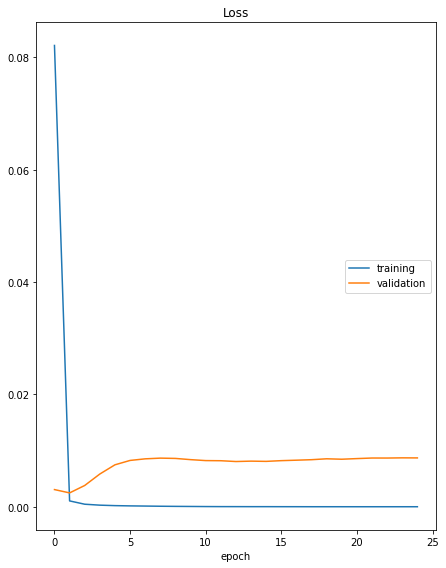

Loss
	training         	 (min:    0.000, max:    0.082, cur:    0.000)
	validation       	 (min:    0.002, max:    0.009, cur:    0.009)


In [7]:
# Fit method
nn_recommender = NNRecommender()
nn_recommender.fit(interactions_df, None, None)

In [9]:
# Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 20)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,110,1.000000,WinterVacation,[2-3],Standard,[260-360],[3-4],False
1,1,86,1.000000,OffSeason,[2-3],Nonref,[260-360],[3-4],True
2,1,82,1.000000,HighSeason,[2-3],Nonref,[160-260],[3-4],False
3,1,6,0.999999,OffSeason,[2-3],Standard,[260-360],[5-inf],True
4,1,69,0.999999,HighSeason,[4-7],Standard,[160-260],[3-4],True
5,1,339,0.999999,HighSeason,[4-7],Nonref,[260-360],[3-4],False
6,1,22,0.999999,OffSeason,[2-3],Standard,[160-260],[3-4],True
7,1,77,0.999999,HighSeason,[2-3],Nonref,[160-260],[3-4],True
8,1,160,0.999999,LowSeason,[2-3],Standard,[160-260],[3-4],True
9,1,75,0.999999,OffSeason,[4-7],Nonref,[160-260],[3-4],True


# Tuning method

In [12]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [13]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

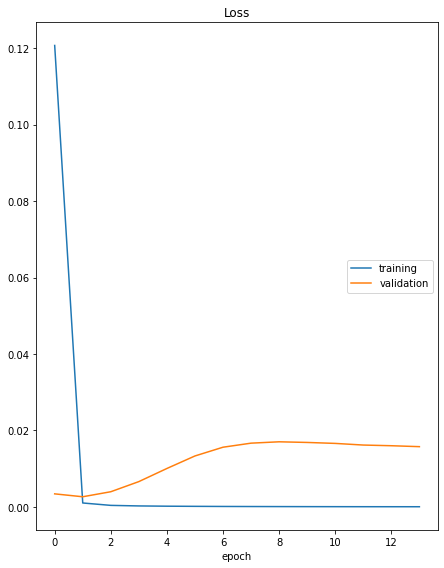

Loss
	training         	 (min:    0.000, max:    0.121, cur:    0.000)
	validation       	 (min:    0.003, max:    0.017, cur:    0.016)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.042088,0.113131,0.154545,0.218182,0.042088,0.083076,0.100233,0.120636


Best parameters:
{'n_epochs': 14.0, 'n_neg_per_pos': 4.0}


In [14]:
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'n_epochs': hp.quniform('n_epochs', 1, 30, 1)
}

#   

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

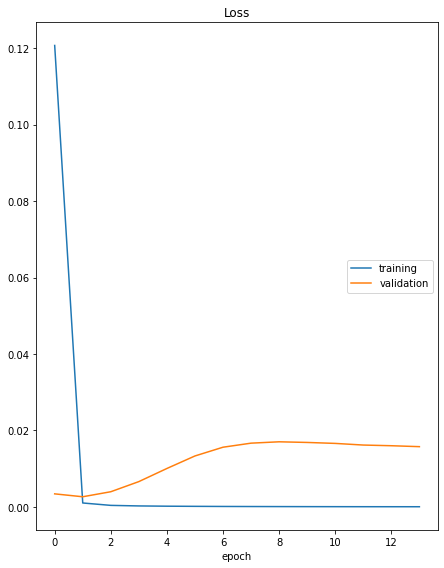

Loss
	training         	 (min:    0.000, max:    0.121, cur:    0.000)
	validation       	 (min:    0.003, max:    0.017, cur:    0.016)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.042088,0.113131,0.154545,0.218182,0.042088,0.083076,0.100233,0.120636


In [19]:
nn_recommender = NNRecommender(n_epochs= 14, n_neg_per_pos= 4)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

In [20]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.041414,0.110438,0.147811,0.206061,0.041414,0.081128,0.096619,0.115276


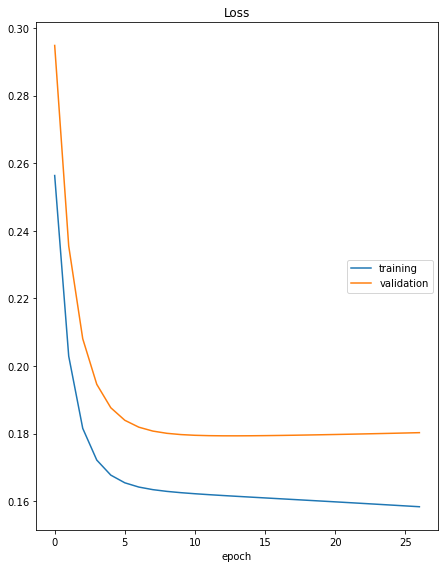

Loss
	training         	 (min:    0.158, max:    0.256, cur:    0.158)
	validation       	 (min:    0.179, max:    0.295, cur:    0.180)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.040404,0.108418,0.144781,0.205724,0.040404,0.079613,0.094772,0.114386


In [21]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(n_epochs=30, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [22]:
tts_results = pd.concat([nn_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.042088,0.113131,0.154545,0.218182,0.042088,0.083076,0.100233,0.120636
1,AmazonRecommender,0.041414,0.110438,0.147811,0.206061,0.041414,0.081128,0.096619,0.115276
2,NetflixRecommender,0.040404,0.108418,0.144781,0.205724,0.040404,0.079613,0.094772,0.114386


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

#### Sumary

* Better results were achieved with the model MLPModel.
* More epochs do not always increase the score.
* The chart of loss is a bit confusing.

#### Scores

| Model             | Score HR@10   | params|
| ---               | ---           | --- |
| GMFModel          | 0.203805       | n_epochs=20, n_neg_per_pos=10, batch_size=16, embedding_dim=6, lr=0.001, weight_decay=0.0001 |
| GMFModel          | 0.201785       | n_epochs=20, n_neg_per_pos=7, batch_size=64, embedding_dim=6, lr=0.01, weight_decay=0.001 |
| GMFModel          | 0.204023      | n_epochs=3, n_neg_per_pos=10, batch_size=64, embedding_dim=12, lr=0.001, weight_decay=0.0001 |
| GMFModel          | 0.206481      | n_epochs=20, n_neg_per_pos=10, batch_size=16, embedding_dim=6, lr=0.001, weight_decay=0.0001, validation_set_size=0.3 |
| GMFModel          | 0.208081      | n_epochs=20, n_neg_per_pos=10, batch_size=16, embedding_dim=4, lr=0.001, weight_decay=0.0001 |
| GMFModel          | 0.200673      | n_epochs=60, n_neg_per_pos=10, batch_size=16, embedding_dim=8, lr=0.001, weight_decay=0.0001 |
| MLPModel          | 0.212795      | n_epochs=25, n_neg_per_pos=10, batch_size=16, embedding_dim=6, lr=0.001, weight_decay=0.0001 |
| MLPModel          | 0.211785      | n_epochs=15, n_neg_per_pos=10, batch_size=16, embedding_dim=6, lr=0.001, weight_decay=0.0001 |
| MLPModel          | 0.209091      | n_epochs=50, n_neg_per_pos=10, batch_size=16, embedding_dim=6, lr=0.001, weight_decay=0.0001 |
| MLPModel          | 0.218182      | n_epochs=14, n_neg_per_pos=4, batch_size=16, embedding_dim=6, lr=0.001, weight_decay=0.0001 |
